# Problem 1: Python & Data Exploration 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!rm -rf hw1 #delete so no repeated folders 
!unzip -q /content/hw1.zip #uploaded zip file google colab by posting zip file in files
%pwd


Mounted at /content/drive


'/content'

In [53]:
%%capture
!pip install -r /content/hw1/requirements.txt 

In [3]:
# Write and run your code here 
import numpy as np
import matplotlib.pyplot as plt

iris = np.genfromtxt("/content/hw1/data/iris.txt",delimiter=None) # load the text file
Y = iris[:,-1] # target value is the last column
#print(Y)
X = iris[:,0:-1] # features are the other columns

In [4]:
X.shape

(148, 4)

The number of features is 4 and there are 148 data points.

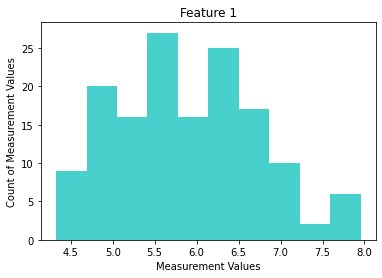

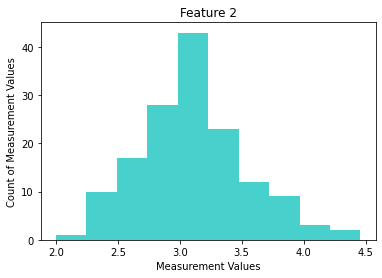

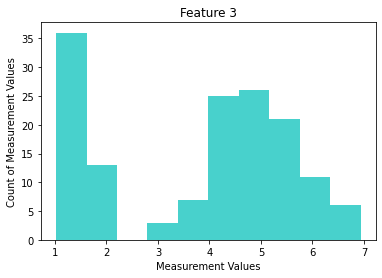

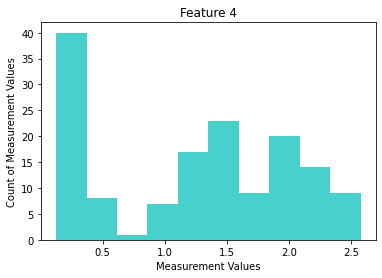

In [5]:
#for each feature has it's own histogram, use for loop
#Use X values as the 4 features values and Y values as the target value column
#print(X) #numpy 2d array
#print(iris) 

for feature in range(4): #Use index to refer to first four columns in iris, don't use X
  #print(feature)
  plt.figure()
  plt.title(f'Feature {feature+1}')
  plt.xlabel('Measurement Values')
  plt.ylabel('Count of Measurement Values')
  plt.hist(iris[:,feature], color = 'mediumturquoise')   #needs X to be a list for plt.hist

In [6]:
#mean and s.d of each feature
#use for loop

sd_feature =  np.std(iris, axis = 0)
mean_feature = iris[:,:-1].mean(axis=0) #for each column do the standard deviation and the mean 

for feature in range(4): 
  print(f'For Feature {feature+1}: \n', "Mean ", sd_feature[feature], "Standard Deviation ", mean_feature[feature])

#print(df)

For Feature 1: 
 Mean  0.8334020667748939 Standard Deviation  5.900103764189187
For Feature 2: 
 Mean  0.43629183800107685 Standard Deviation  3.0989309168918915
For Feature 3: 
 Mean  1.7540571093439352 Standard Deviation  3.8195548405405413
For Feature 4: 
 Mean  0.7587724570263246 Standard Deviation  1.252555484594594


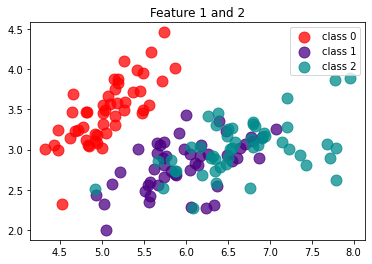

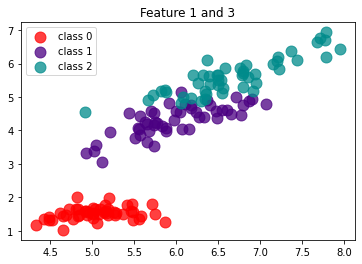

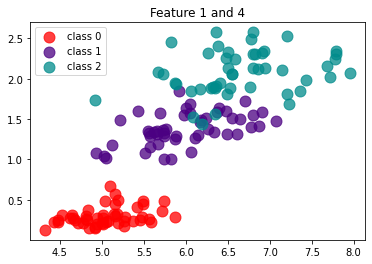

In [7]:
#target value is class 0-2, 4 features (identifications)
import numpy as np
colors = ['red', 'indigo', 'darkcyan']

for feature in range(3): #making 3 scatterplots

  new_iris = iris[:, -1]  #np.unique(new_iris) finds the class number value (to mask)
  for i, c in enumerate(np.unique(new_iris)):  #enum keeps track index,value
      mask = iris[:, -1] == c  # Finding the right points
      plt.scatter(iris[mask, 0], iris[mask, feature+1], s=120, c=colors[i], alpha=0.75, label='class %d' % i)
  plt.title(f'Feature 1 and {feature+2}')

  plt.legend() 
  plt.show()

# Problem 2: k-Nearest Neighbor (kNN) exercise


The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [8]:
# Run some setup code for this notebook.
import random
import numpy as np
from hw1.cs273p.data_utils import load_CIFAR10 #path
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# %load_ext autoreload
# %autoreload 2

In [9]:
%cd hw1/cs273p/datasets  
!source get_datasets.sh 
%pwd

/content/hw1/cs273p/datasets
--2023-01-21 22:18:32--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  49.2MB/s    in 3.7s    

2023-01-21 22:18:37 (44.4 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


'/content/hw1/cs273p/datasets'

In [10]:
%cd ../..

/content/hw1


In [11]:
# Load the raw CIFAR-10 data.
cifar10_dir = '/content/hw1/cs273p/datasets/cifar-10-batches-py'   #copied path, opened the get datasets to get cifar
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


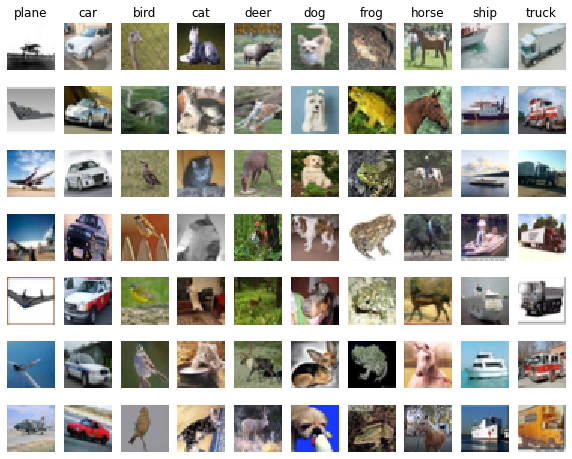

In [12]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [13]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [14]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [15]:
from hw1.cs273p.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
#print(classifier)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `cs273p/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [16]:
# Open cs273p/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops function
!python /content/hw1/cs273p/classifiers/k_nearest_neighbor.py


In [17]:
# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)
#dists

(500, 5000)


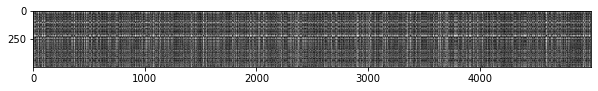

In [18]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples

#each row is each picture and each column is the pixel making it up
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

**Your Answer**: The bright rows is because the image in training set is really different/far than the image in testing set. The bright columns means images in the test set is really different from the image in the training set.



In [19]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [20]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

In [21]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [22]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [23]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 42.904379 seconds
One loop version took 39.814995 seconds
No loop version took 0.611415 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [114]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################ 
X_train_folds = np.array_split(X_train,num_folds)
y_train_folds = np.array_split(y_train,num_folds) #y_train is the labels "classify"

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies =  {}

################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
for k in k_choices:
    k_to_accuracies[k] = [] #want to repeat 5 times

    for fold in range(num_folds): #This fold will be omitted.
        #Creating validation data and temp training data

        validation_X_test = X_train_folds[fold]
        validation_y_test = y_train_folds[fold]
        temp_X_train = np.concatenate(X_train_folds[:fold] + X_train_folds[fold + 1:])
        temp_y_train = np.concatenate(y_train_folds[:fold] + y_train_folds[fold + 1:])

        #Initializing a class
        test_classifier = KNearestNeighbor()
        test_classifier.train( temp_X_train, temp_y_train )
        
        #Computing the distance
        temp_dists = test_classifier.compute_distances_no_loops(validation_X_test)
        temp_y_test_pred = test_classifier.predict_labels(temp_dists, k=k)
        
        #Checking accuracies
        num_correct = np.sum(temp_y_test_pred == validation_y_test)
        num_test = validation_X_test.shape[0]
        accuracy = float(num_correct) / num_test
        k_to_accuracies[k].append(accuracy)
        #k_to_accuracies[k] = k_to_accuracies.get(k,[]) + [accuracy]

# for k in k_choices: #go through each k
#   temp = []
#   for i in range(num_folds): #running through each fold 5 times, the "index"
#           x_train_val = X_train_folds[i] #an array specified in X_train_folds list, try to get rid and replace
#           y_train_val  = y_train_folds[i]

#           new_X_set = np.concatenate(X_train_folds[:i] + X_train_folds[i+1:]) #add everthing but current array from the "set/list"
#           new_y_set = np.concatenate(y_train_folds[:i] + y_train_folds[i+1:]) #same, but 'labels' for X

          
#           classifier = KNearestNeighbor()
#           classifier.train(new_X_set,new_y_set)  

#           dists = classifier.compute_distances_no_loops(new_X_set) #use knn algo      
#           y_label_predict = classifier.predict_labels(dists, k=k)#now get the labels 

#           accuracy_sum = np.sum(y_label_predict ==  new_y_set ) 
#           accuracy_proportion = float(accuracy_sum) / new_y_set.shape[0]
#           temp.append(accuracy_proportion)  #list saved here
#   k_to_accuracies[k] = temp #append, percentage correct with k


        

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

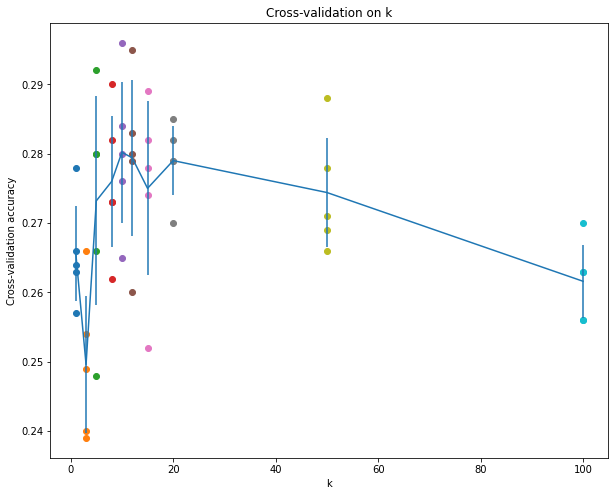

In [115]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [116]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = k_choices[np.argmax(accuracies_mean)]
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / X_test.shape[0]
print( 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 1000 correct => accuracy: 0.282000


# Problem 3: Naïve Bayes Classifiers


You don't need to code this question. You can either type your answer or attach an image of hand written solution here.

In [117]:
#written separately